In [1]:
import numpy as np
import torch
import os
import h5py
os.chdir('../networks')
from afnonet import AFNONet
os.chdir('../utils')
from collections import OrderedDict
from YParams import YParams
from darcy_loss import LpLoss
# from data_loader_multifiles import get_data_loader
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors

# train_data_loader, train_dataset, train_sampler = get_data_loader(params, params.train_data_path, False, train=True)

In [2]:
import logging
import glob
import torch
import random
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.distributed import DistributedSampler
from torch import Tensor
import h5py
import math
#import cv2
from img_utils import reshape_fields, reshape_precip, sphere_to_torus_np, glide_reflection_np

def get_data_loader(params, files_pattern, distributed, train):
  distributed = False
  dataset = GetDataset(params, files_pattern, train)
  seed = torch.random.seed() if train else 0
  sampler = DistributedSampler(dataset, shuffle=train, seed=seed) if distributed else None

  dataloader = DataLoader(dataset,
                          batch_size=int(params.batch_size),
                          num_workers=0,
                          shuffle=False, #(sampler is None),
                          sampler=sampler, # Since validation is on a subset, use a fixed random subset,
                          drop_last=True,
                          pin_memory=torch.cuda.is_available())

  if train:
    return dataloader, dataset, sampler
  else:
    return dataloader, dataset


class GetDataset(Dataset):
    def __init__(self, params, location, train):
        self.params = params
        self.location = location
        self.train = train
        self.dt = params.dt
        self.n_history = params.n_history
        self.in_channels = np.array(params.in_channels)
        self.out_channels = np.array(params.out_channels)
        self.n_in_channels = len(self.in_channels)
        self.n_out_channels = len(self.out_channels)
        self.crop_size_ns = params.crop_size_x
        self.crop_size_ew = params.crop_size_y
        self.roll = params.roll
        self.flip = params.flip
        self._get_files_stats()
        self.rollout_length = params.rollout_length if train else params.valid_rollout_length
        self.two_step_training = params.two_step_training
        self.orography = params.orography
        self.precip = True if "precip" in params else False
        if self.precip:
            path = params.precip+'/train' if train else params.precip+'/test'
            self.precip_paths = glob.glob(path + "/*.h5")
            self.precip_paths.sort()

        try:
            self.normalize = params.normalize
        except:
            self.normalize = True #by default turn on normalization if not specified in config

        if self.orography:
          self.orography_path = params.orography_path

    def _get_files_stats(self):
        self.files_paths = glob.glob(self.location + "/*.h5")
        self.files_paths.sort()
        # 1999 is broken. Remove this if it gets fixed
        self.files_paths = [name for name in self.files_paths if '1999' not in name]
        self.n_years = len(self.files_paths)

        with h5py.File(self.files_paths[0], 'r') as _f:
            logging.info("Getting file stats from {}".format(self.files_paths[0]))
            self.n_samples_per_year = _f['fields'].shape[0]
            #original image shape (before padding)
            self.img_shape_ns = _f['fields'].shape[2] -1#just get rid of one of the pixels
            self.img_shape_ew = _f['fields'].shape[3]

        self.n_samples_total = self.n_years * self.n_samples_per_year
        self.files = [None for _ in range(self.n_years)]
        self.precip_files = [None for _ in range(self.n_years)]
        logging.info("Number of samples per year: {}".format(self.n_samples_per_year))
        logging.info("Found data at path {}. Number of examples: {}. Image Shape: {} x {} x {}".format(self.location, self.n_samples_total, self.img_shape_ns, self.img_shape_ew, self.n_in_channels))
        logging.info("Delta t: {} hours".format(6*self.dt))
        logging.info("Including {} hours of past history in training at a frequency of {} hours".format(6*self.dt*self.n_history, 6*self.dt))


    def _open_file(self, year_idx):
        _file = h5py.File(self.files_paths[year_idx], 'r')
        self.files[year_idx] = _file['fields']
        if self.orography:
          _orog_file = h5py.File(self.orography_path, 'r')
          self.orography_field = _orog_file['orog']
        if self.precip:
          self.precip_files[year_idx] = h5py.File(self.precip_paths[year_idx], 'r')['tp']


    def __len__(self):
        return self.n_samples_total


    def __getitem__(self, global_idx):
        year_idx = int(global_idx/self.n_samples_per_year) #which year we are on
        local_idx = int(global_idx%self.n_samples_per_year) #which sample in that year we are on - determines indices for centering
        k = self.rollout_length


        #open image file
        if self.files[year_idx] is None:
            self._open_file(year_idx)

        if not self.precip:
          #if we are not at least self.dt*n_history timesteps into the prediction
          if local_idx < self.dt*self.n_history:
              local_idx += self.dt*self.n_history

          #if we are on the last image in a year predict identity, else predict next timestep
          # step = 0 if local_idx >= self.n_samples_per_year-self.dt else self.dt
        else:
          inp_local_idx = local_idx
          tar_local_idx = local_idx
          #if we are on the last image in a year predict identity, else predict next timestep
          step = 0 if tar_local_idx >= self.n_samples_per_year-self.dt else self.dt
          # first year has 2 missing samples in precip (they are first two time points)
          if year_idx == 0:
            lim = 1458
            local_idx = local_idx%lim
            inp_local_idx = local_idx + 2
            tar_local_idx = local_idx
            step = 0 if tar_local_idx >= lim-self.dt else self.dt

        #if two_step_training flag is true then ensure that local_idx is not the last or last but one sample in a year
        if local_idx >= self.n_samples_per_year - k*self.dt:
            #set local_idx to last possible sample in a year that allows taking two steps forward
            local_idx = self.n_samples_per_year - (k+1)*self.dt
        step = self.dt

        if self.train and self.roll:
          ew_roll = random.randint(0, self.img_shape_ew)
          if self.params.dfs_type == 'full':
            ns_roll = random.randint(0, self.img_shape_ns)
          else:
            ns_roll = 0
        else:
          ew_roll = 0
          ns_roll = 0

        if self.train and self.flip:
          ew_flip = int(random.random() < .5)
          ns_flip = int(random.random() < .5)
        else:
          ew_flip = 0
          ns_flip = 0


        if self.orography:
            orog = self.orography_field[0:720]
        else:
            orog = None
        # Cropping doesn't really make sense, but leaving the code here since it's not used - Mike
        if self.train and (self.crop_size_ns or self.crop_size_ew):
          rnd_x = random.randint(0, self.img_shape_ns-self.crop_size_ns)
          rnd_y = random.randint(0, self.img_shape_ew-self.crop_size_ew)
        else:
          rnd_x = 0
          rnd_y = 0

        if self.precip:
          return reshape_fields(self.files[year_idx][inp_local_idx, self.in_channels], 'inp', self.crop_size_ns, self.crop_size_ew, rnd_x, rnd_y,self.params, y_roll, self.train), \
                    reshape_precip(self.precip_files[year_idx][tar_local_idx+step], 'tar', self.crop_size_ns, self.crop_size_ew, rnd_x, rnd_y, self.params, y_roll, self.train)
        else:
            return reshape_fields(self.files[year_idx][(local_idx-self.dt*self.n_history):(local_idx+1):self.dt, self.in_channels], 'inp', self.crop_size_ns, self.crop_size_ew, rnd_x, rnd_y,self.params, ns_roll, ew_roll, self.train, self.normalize, orog), \
                        reshape_fields(self.files[year_idx][local_idx + step:local_idx + step + k, self.out_channels], 'tar', self.crop_size_ns, self.crop_size_ew, rnd_x, rnd_y, self.params, ns_roll, ew_roll, ns_flip, ew_flip, self.train, self.normalize, orog), year_idx, local_idx, (ns_roll, ew_roll, ns_flip, ew_flip)



In [3]:

params = YParams(os.path.abspath('../config/AFNO_interactive.yaml'), 'afno_backbone')
# params['normalize'] = 'taco'
params['batch_size'] = 1
params['rollout_length'] = 1



def glide_reflection(x, flip_dim=-2, glide_dim=-1):
    n_ew = x.shape[glide_dim]
    flipped_x = torch.flip(x, dims=(-2,))
    return torch.roll(flipped_x, shifts=n_ew // 2, dims=-1)


def sphere_to_torus(x, flip_dim=-2, glide_dim=-1):
    """ Performs a sphere to torus mapping for lat/long by reflecting and 
    shifting the input so that both the x and y directions are periodic. 

    Currently assumes (..., c, h, w) format. 
    """
    return torch.cat([x, glide_reflection(x, flip_dim=flip_dim, glide_dim=glide_dim)], dim=-2)



train_data_loader, train_dataset, train_sampler = get_data_loader(params, params.train_data_path, False, train=True)



In [4]:
with torch.no_grad():

    total_means = torch.zeros(1, 20, 1440, 721)
    lat_means = torch.zeros(1, 20, 1440, 721)
    lon_means = torch.zeros(1, 20, 721, 1440)
    lats = []
    tots = []
    count = 0
    for data in train_data_loader:
        break
        x, y, year, local = data
        break
        x = sphere_to_torus(x)
        
        xlats = torch.fft.rfft(x, dim=-1, norm='ortho')#.abs()
        xlons = torch.fft.rfft(x, dim=-2, norm='ortho')
        # print(xlats.abs().sum((2, 3))/(1440*721))
        lat_means = lat_means + xlats.abs()
        lon_means = lon_means + xlons.abs()
        # lats.append(xlats)
        # xfft =torch.fft.fftshift(torch.fft.rfft2(x).abs(), dim = -2)
        xfft = torch.fft.rfft2(x, norm='ortho')
        # tots.append(xfft)
        xfft_abs = xfft.abs()

        total_means = total_means + xfft_abs
        count += 1
        if count >= 200:
            break
        xlats_last = xlats
        
        # if count > 10:
        #     tots.pop()

    total_means = total_means / count
    lat_means = lat_means / count
    lon_means /= count
    # lats = torch.cat(lats, 0)
    # tots = torch.cat(tots, 0)
#     outlier = np.abs(x.numpy().mean((0, 2, 3)))
#     outlier_var = np.abs(np.std(x.numpy(), axis=(0, 2, 3)))
#     outlier_var[16] = 1
#     if np.any(outlier > .3):
#         print('outlier mean', year.item(), local.item(), outlier)
#     if np.any(np.abs(outlier_var-1) > .4):
#         print('outlier var', year.item(), local.item(), outlier_var)


[1, 7, 10, 13] (20, 1440, 1440)
(20, 4, 720)
(20, 4, 720)
[1, 7, 10, 13] (20, 1440, 1440)
(20, 4, 720)
(20, 4, 720)


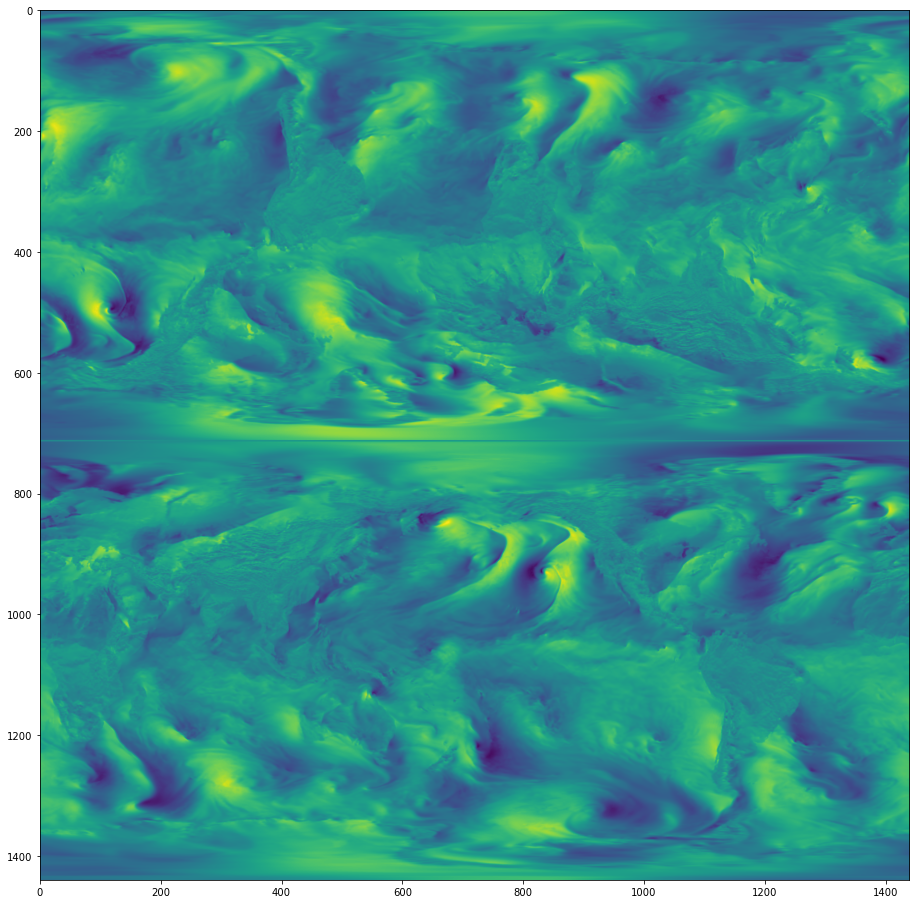

In [5]:
fig = plt.figure(figsize=(16, 16))

plt.imshow(data[0][0][1])

In [13]:
torch.fft.fftshift(torch.fft.fftfreq(10))*10

tensor([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])

In [14]:
torch.fft.fftshift(torch.fft.fftfreq(20))[5:-5]*20

tensor([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])

<AxesSubplot:>

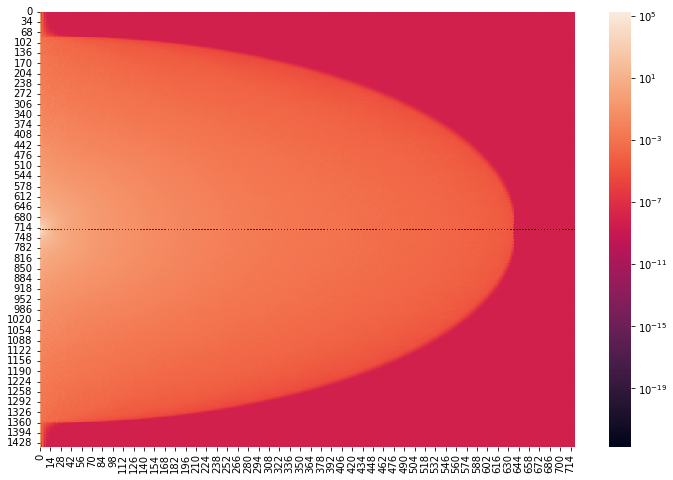

In [5]:
fig = plt.figure(figsize=(12, 8))
sns.heatmap(torch.fft.fftshift(total_means**2, dim=-2)[0][9], norm=colors.LogNorm())

In [ ]:
F.inte

In [6]:
fft2_masks = (total_means > .0004).int()
lfft_masks = (lat_means > .0003).int()

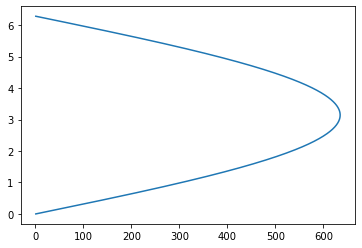

In [51]:
plt.plot(1 + np.cos(np.linspace(-np.pi/2, np.pi/2, 720))*634, np.linspace(0, 2*np.pi, 720))
# plt.plot( np.linspace(0, 2*np.pi, 1440)

In [30]:
(.5*(1+np.cos(np.linspace(-np.pi, np.pi, 1440)))*721).sum() / (721 * 1440)

0.4996527777777778

In [29]:
.5*(1+np.cos(np.linspace(-np.pi, np.pi, 1440))

1.9999976168685976

In [28]:
def oned_butterworth(n, cutoff, order, real=True):
    if real:
        coefs = ((torch.fft.rfftfreq(n)*n) / cutoff)**2
    else:
        coefs = ((torch.fft.fftfreq(n).abs()*n) / cutoff)**2
    return 1 / (1 + coefs**order)

chan_stack = []


B = 90
for k in range(0, 20):
    lat_stack = []
    for i in range(lfft_masks.shape[2]):
        # try:
        cutoff = torch.quantile(torch.where(lfft_masks[0][k][i] > 0)[0].float(), .995) + .5
        cutoff = torch.quantile(torch.where(lfft_masks[0][k][i] > 0)[0].float(), .995) + .5

        # print(cutoff)
        filt = oned_butterworth(1440, (max(1, int(cutoff))/634 * B), 8)
        

        lat_stack.append(filt)
        # if i > 300:
        #     print(cutoff, filt)
        #     break
        
    chan_stack.append(torch.stack(lat_stack))

filters = torch.stack(chan_stack).unsqueeze(0)
        # except:
            # print('full size')
    # print(i, cutoff)
    # break

<AxesSubplot:>

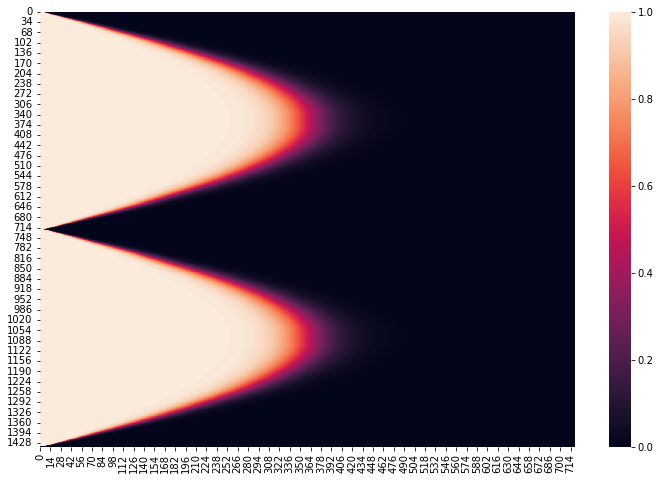

In [16]:
fig = plt.figure(figsize=(12, 8))
sns.heatmap(filters[0][9])

In [ ]:
from typing import Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.common_types import _size_2_t


fi = [[[[0.0000,0.0000,0.0001,0.0000,0.0000],
[0.0000,0.0111,0.0833,0.0111,0.0000],
[0.0001,0.0833,0.6220,0.0833,0.0001],
[0.0000,0.0111,0.0833,0.0111,0.0000],
[0.0000,0.0000,0.0001,0.0000,0.0000],]]]

def _default_2d_filter():
    default_filter = torch.tensor(fi)
    
    
    # torch.tensor([[[
    #     [.0023, .0432, .0023],
    #     [.0432, .8180, .0432],
    #     [.0023, .0432, .0023],
    # ]]]) #* 1 / 44.0

    return default_filter

def blur_2d(input: torch.Tensor, stride: _size_2_t = 1, filter: torch.Tensor = None) -> torch.Tensor:
    """Applies a spatial low-pass filter.
    Args:
        input (torch.Tensor): A 4d tensor of shape NCHW
        stride (int | tuple, optional): Stride(s) along H and W axes. If a single value is passed, this
            value is used for both dimensions.
        filter (torch.Tensor, optional): A 2d or 4d tensor to be cross-correlated with the input tensor
            at each spatial position, within each channel. If 4d, the structure
            is required to be ``(C, 1, kH, kW)`` where ``C`` is the number of
            channels in the input tensor and ``kH`` and ``kW`` are the spatial
            sizes of the filter.
    By default, the filter used is:
    .. code-block:: python
            [1 2 1]
            [2 4 2] * 1/16
            [1 2 1]
    Returns:
        The blurred input
    """
    _, c, h, w = input.shape
    n_in_channels = c

    if filter is None:
        filter = _default_2d_filter().cuda()
    if (filter.shape[0] == 1) and (n_in_channels > 1):
        # filt is already a rank 4 tensor
        filter = filter.repeat((n_in_channels, 1, 1, 1))

    _, _, filter_h, filter_w = filter.shape
#     padding = _padding_for_filt_2d_same(filter)

#     if h + 2 * padding[0] < filter_h:
#         return input
#     if w + 2 * padding[1] < filter_w:
#         return input
    input = F.pad(input, (2, 2, 2, 2), 'circular')

    return F.conv2d(input, filter, stride=stride, padding=0, groups=n_in_channels, bias=None)


class BlurConv2d(nn.Module):
    """This module is a drop-in replacement for :class:`torch.nn.Conv2d`, but with an anti-aliasing filter.
    The one new parameter is ``blur_first``. When set to ``True``, the
    anti-aliasing filter is applied before the underlying convolution and
    vice-versa when set to ``False``. This mostly makes a difference when the
    stride is greater than one. In the former case, the only overhead is the
    cost of doing the anti-aliasing operation. In the latter case, the ``Conv2d``
    is applied with a stride of one to the input, and then the
    anti-aliasing is applied with the provided stride to the result. Setting
    the stride of the convolution to ``1`` can greatly increase the computational
    cost. E.g., replacing a stride of ``(2, 2)`` with a stride of ``1`` increases
    the number of operations by a factor of ``(2/1) * (2/1) = 4``. However,
    this approach most closely matches the behavior specified in the paper.
    This module should only be used to replace strided convolutions.
    See the associated `paper <http://proceedings.mlr.press/v97/zhang19a.html>`_
    for more details, experimental results, etc.
    See also: :func:`~blur_2d`.
    """

    # based partially on https://pytorch.org/docs/stable/_modules/torch/nn/modules/conv.html#Conv2d

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size: _size_2_t,
                 stride: _size_2_t = None,
                 padding: _size_2_t = 0,
                 dilation: _size_2_t = 1,
                 groups: int = 1,
                 bias: bool = True,
                 blur_first: bool = True):

        super(BlurConv2d, self).__init__()
        self.blur_first = blur_first

        if self.blur_first:
            assert stride is not None
            conv_stride = stride
            self.blur_stride = 1
            blur_nchannels = in_channels
        else:
            conv_stride = 1
            self.blur_stride = kernel_size if (stride is None) else stride
            blur_nchannels = out_channels

        self.conv = torch.nn.Conv2d(in_channels=in_channels,
                                    out_channels=out_channels,
                                    kernel_size=kernel_size,
                                    stride=conv_stride,
                                    padding=padding,
                                    dilation=dilation,
                                    groups=groups,
                                    bias=bias)

        # this is the full 4d tensor we want; materialize it once, instead
        # of just-in-time during forward; we can do this in this class but
        # not the others because we know in_channels during __init__
        filt = _default_2d_filter().repeat(blur_nchannels, 1, 1, 1)
        self.register_buffer('blur_filter', filt)

    def forward(self, input: torch.Tensor):
        if self.blur_first:
            # blur in place, then apply (probably strided) conv
            # this is roughly the same number of flops as just applying
            # the original conv (though has some memory bandwidth cost)
            blurred = blur_2d(input, filter=self.blur_filter, stride=self.blur_stride)
            return self.conv.forward(blurred)
        else:
            # apply conv with stride of 1, then blur and (probably) downsample;
            # this is much more costly than a strided conv, at least in the
            # compute-bound regime
            activations = self.conv.forward(input)
            return blur_2d(activations, filter=self.blur_filter, stride=self.blur_stride)

    @staticmethod
    def from_conv2d(module: torch.nn.Conv2d, module_index: int = -1, blur_first: bool = True):
        has_bias = module.bias is not None and module.bias is not False
        blurconv = BlurConv2d(in_channels=module.in_channels,
                              out_channels=module.out_channels,
                              kernel_size=module.kernel_size,
                              stride=module.stride,
                              padding=module.padding,
                              dilation=module.dilation,
                              groups=module.groups,
                              bias=has_bias,
                              blur_first=blur_first)

        with torch.no_grad():
            blurconv.conv.weight.copy_(module.weight)
            if has_bias:
                blurconv.conv.bias.copy_(module.bias)

        return blurconv




In [15]:
%timeit torch.fft.rfft2(x.cuda())

9.65 ms ± 9.45 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
%timeit blur_2d(x.cuda())

11.2 ms ± 3.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


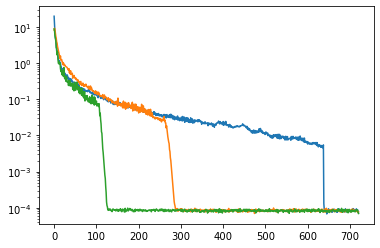

In [44]:
# plt.semilogy(xlats.abs().mean(-2)[0][0])

# xblur = blur_2d(blur_2d(blur_2d(x)))
# xblur_lats = torch.fft.rfft(xblur, norm='ortho')

plt.semilogy(lat_means.abs().mean(0)[9][360])
plt.semilogy(lat_means.abs().mean(0)[9][100])
plt.semilogy(lat_means.abs().mean(0)[9][680])



# print((xblur -x).abs().max(), (xblur -x).abs().mean())

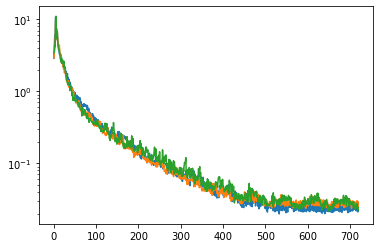

In [62]:
# plt.semilogy(xlats.abs().mean(-2)[0][0])

# xblur = blur_2d(blur_2d(blur_2d(x)))
# xblur_lats = torch.fft.rfft(xblur, norm='ortho')

plt.semilogy(lon_means.abs().mean(0)[0][:, 0])
plt.semilogy(lon_means.abs().mean(0)[0][:, 300])
plt.semilogy(lon_means.abs().mean(0)[0][:, 1000])


In [52]:
lon_means.shape

torch.Size([1, 20, 721, 1440])

In [ ]:
plt.semilogy(xlats.abs().mean(-2)[0][0])

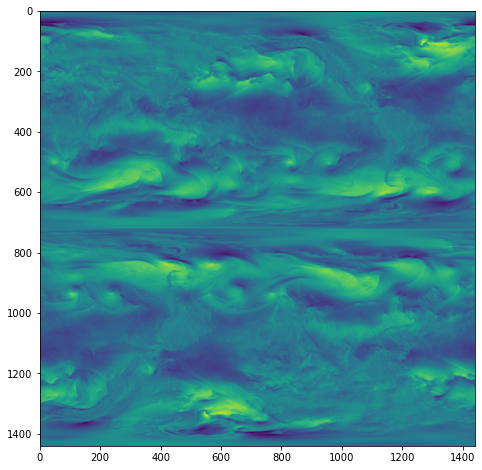

In [20]:
def latwise_butterworth(x, cut_points, order):
    """ Cut points should be B, C, (Longitudes), (1) """
    denominator = 1 + (x/cut_points)

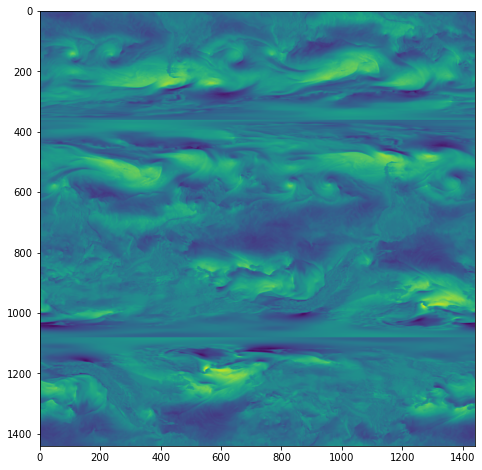

In [23]:
fig = plt.figure(figsize=(12, 8))
plt.imshow(torch.fft.irfft2(torch.fft.rfft2(x[0][0])*torch.exp(2j*np.pi*(.5*torch.arange(721).reshape(1, -1) + .25*torch.arange(-720, 720).reshape(-1, 1)))))

In [129]:
zonal = torch.linalg.norm(tots, dim=2).mean(0).reshape(1, 20, 1, -1)
merids = torch.linalg.norm(tots, dim=-1).mean(0).reshape(1, 20, -1, 1)

In [27]:
import torch.nn as nn


# ns_bw_small = oned_butterworth(1440, 360, 8, False).reshape(1, 1, -1, 1)
ns_bw = oned_butterworth(1440, 9, 8, False).reshape(1, 1, -1, 1)
# np.save('/pscratch/sd/m/mmccabe/data/era5/lfft_masks.npy', lfft_masks.numpy().astype(np.uint8))
# np.save('/pscratch/sd/m/mmccabe/data/era5/fft2_masks.npy', fft2_masks.numpy().astype(np.uint8))
# np.save('/pscratch/sd/m/mmccabe/data/era5/zonal_avgs.npy', zonal.numpy())
# np.save('/pscratch/sd/m/mmccabe/data/era5/merid_avgs.npy', merids.numpy())
# np.save('/pscratch/sd/m/mmccabe/data/era5/bworth_small.npy', filters.numpy())
# np.save('/pscratch/sd/m/mmccabe/data/era5/bworth_ns_small.npy', ns_bw_small.numpy())
# np.save('/pscratch/sd/m/mmccabe/data/era5/bworth_ns.npy', ns_bw.numpy())

# np.save('/pscratch/sd/m/mmccabe/data/era5/ew_bworth_quadratic.npy', filters.numpy())
# np.save('/pscratch/sd/m/mmccabe/data/era5/ns_bworth_quadratic.npy', ns_bw.numpy())


# np.save('/pscratch/sd/m/mmccabe/data/era5/ew_bworth_cubic.npy', filters.numpy())
# np.save('/pscratch/sd/m/mmccabe/data/era5/ns_bworth_cubic.npy', ns_bw.numpy())



# np.save('/pscratch/sd/m/mmccabe/data/era5/ew_bworth_linear.npy', filters.numpy())
# np.save('/pscratch/sd/m/mmccabe/data/era5/ns_bworth_linear.npy', ns_bw.numpy())

np.save('/pscratch/sd/m/mmccabe/data/era5/ew_bworth_tiny.npy', filters.numpy())
np.save('/pscratch/sd/m/mmccabe/data/era5/ns_bworth_tiny.npy', ns_bw.numpy())

# filters


In [92]:
fft2_masks[0, 9].sum() / fft2_masks[0, 9].numel()

tensor(0.6258)

In [84]:
x = lambda x:

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

In [19]:
import scipy.signal as signal

signal.butter(2, Wn

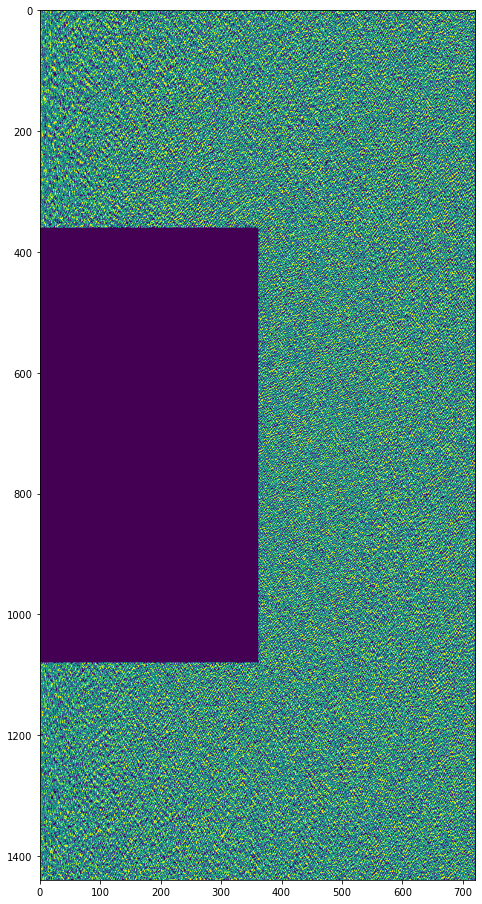

In [53]:

import torch.nn as nn
class AliasLevelSplit(nn.Module):
    def forward(self, x):
        outs = []
        x = torch.fft.fftshift(x, dim=2)
        for level in range(3, -1, -1):
            res = torch.zeros_like(x)
            res[:, :, 1440//2 - (1440//2**(level+1)):1440//2+(1440//2**(level+1)), :1440//2**level //2 +1] = x[:, :, 1440//2 - (1440//2**(level+1)):1440//2+(1440//2**(level+1)), :1440//2**level //2 +1]
            for out in outs:
                res = res - out
            outs.append(res)
        return tuple(outs)

    
splitter = AliasLevelSplit()
outs = splitter(xfft)
fig = plt.figure(figsize=(16, 16))
plt.imshow((outs[3].real>0)[0][0])

In [ ]:
class AliasLevelSplit(nn.Module):
    def forward(self, x):
        outs = []
        x = torch.fft.fftshift(x, dim=2)
        for level in range(3, -1, -1):
            res = torch.zeros_like(x)
            res[:, :, 1440//2 - (1440//2**(level+1)):1440//2+(1440//2**(level+1)), :1440//2**level //2 +1] = x[:, :, 1440//2 - (1440//2**(level+1)):1440//2+(1440//2**(level+1)), :1440//2**level //2 +1]
            for out in outs:
                res = res - out
            outs.append(res)
        return tuple(outs)

def rebalance_losses(m, grad_inputs, grad_outputs):
    grad_norm1 = torch.linalg.norm(grad_outputs[0])
    rescaled_gn1 = grad_outputs[0] / grad_norm1
    out = grad_outputs[0].clone()
    for i, grad in enumerate(grad_outputs[1:]):
        out = out + grad
        #grad = grad / torch.linalg.norm(grad)
        #proj = (out*grad).sum()
        #print(i, proj)
        #if proj < 0:
        #    grad = grad - proj*out
        #out += grad
        #out /= torch.linalg.norm(out)
    #return (out,)#(grad_norm1*out,)


class RescaledMSE(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.MSELoss()
        self.splitter = AliasLevelSplit()
        self.splitter.register_full_backward_hook(rebalance_losses)
        self.y_splitter = AliasLevelSplit()
    def forward(self, x, y):
        xs = self.splitter(x)
        ys = self.y_splitter(y)

        return sum([self.loss(x, y) for x, y in zip(xs, ys)])

    
    


In [58]:
filters.shape

torch.Size([1, 20, 1440, 721])

In [24]:
def mask_transform(x):
    x = torch.fft.rfft(x, norm='ortho')
    x = x * lfft_masks#[:, 9:10]
    x = torch.fft.fft(x, dim=-2, norm='ortho') * fft2_masks#[:, 9:10]
    x = torch.fft.irfft2(x, norm='ortho')
    return x

def mean_transform(x, xlats_last):
    x = torch.fft.rfft2(x, norm='ortho')
    # orig_norm = torch.linalg.norm(x)
#     
    # x = x / (1e-5+x.abs()) * tots.abs().mean(0, keepdims=True)
    
    
    
#     new_norms = torch.linalg.norm(tots[..., 90:-90, :], dim=-1).mean(0).reshape(1, 20, -1, 1)
#     x[..., 90:-90, :] = (x[..., 90:-90, :] / torch.linalg.norm(x[..., 90:-90, :], dim=-1).reshape(1, 20, -1, 1)) * new_norms
    
#     new_norms = torch.linalg.norm(tots, dim=2).mean(0).reshape(1, 20, 1, -1)[..., 92:]
#     x[..., 92:] = (x[..., 92:]  / torch.linalg.norm(x[..., 92:] , dim=2).reshape(1, 20, 1, -1)) * new_norms
    
#     new_norms = torch.linalg.norm(tots[..., 90:-90, :], dim=-1).mean(0).reshape(1, 20, -1, 1)
#     x[..., 90:-90, :] = (x[..., 90:-90, :] / torch.linalg.norm(x[..., 90:-90, :], dim=-1).reshape(1, 20, -1, 1)) * new_norms
    
#     new_norms = torch.linalg.norm(tots, dim=2).mean(0).reshape(1, 20, 1, -1)[..., 92:]
#     x[..., 92:] = (x[..., 92:]  / torch.linalg.norm(x[..., 92:] , dim=2).reshape(1, 20, 1, -1)) * new_norms

#     new_norms = torch.linalg.norm(tots[..., 90:-90, :], dim=-1).mean(0).reshape(1, 20, -1, 1)
#     x[..., 90:-90, :] = (x[..., 90:-90, :] / torch.linalg.norm(x[..., 90:-90, :], dim=-1).reshape(1, 20, -1, 1)) * new_norms
    
#     new_norms = torch.linalg.norm(tots, dim=2).mean(0).reshape(1, 20, 1, -1)[..., 92:]
#     x[..., 92:] = (x[..., 92:]  / torch.linalg.norm(x[..., 92:] , dim=2).reshape(1, 20, 1, -1)) * new_norms
    
    return torch.fft.irfft2(x, norm='ortho')


def bworth(x):
    x = torch.fft.rfft(x)
    x *= filters[:, 9:10]
    x = torch.fft.fft(x, dim=-2)
    x *= ns_bw
    return torch.fft.irfft2(x)

sns.heatmap(total_means[0][8].abs(), norm=colors.LogNorm(vmin=np.percentile(total_means[0][19].abs(), 1), vmax=np.percentile(total_means[0][19].abs(), 99)))


tensor(0.0077)


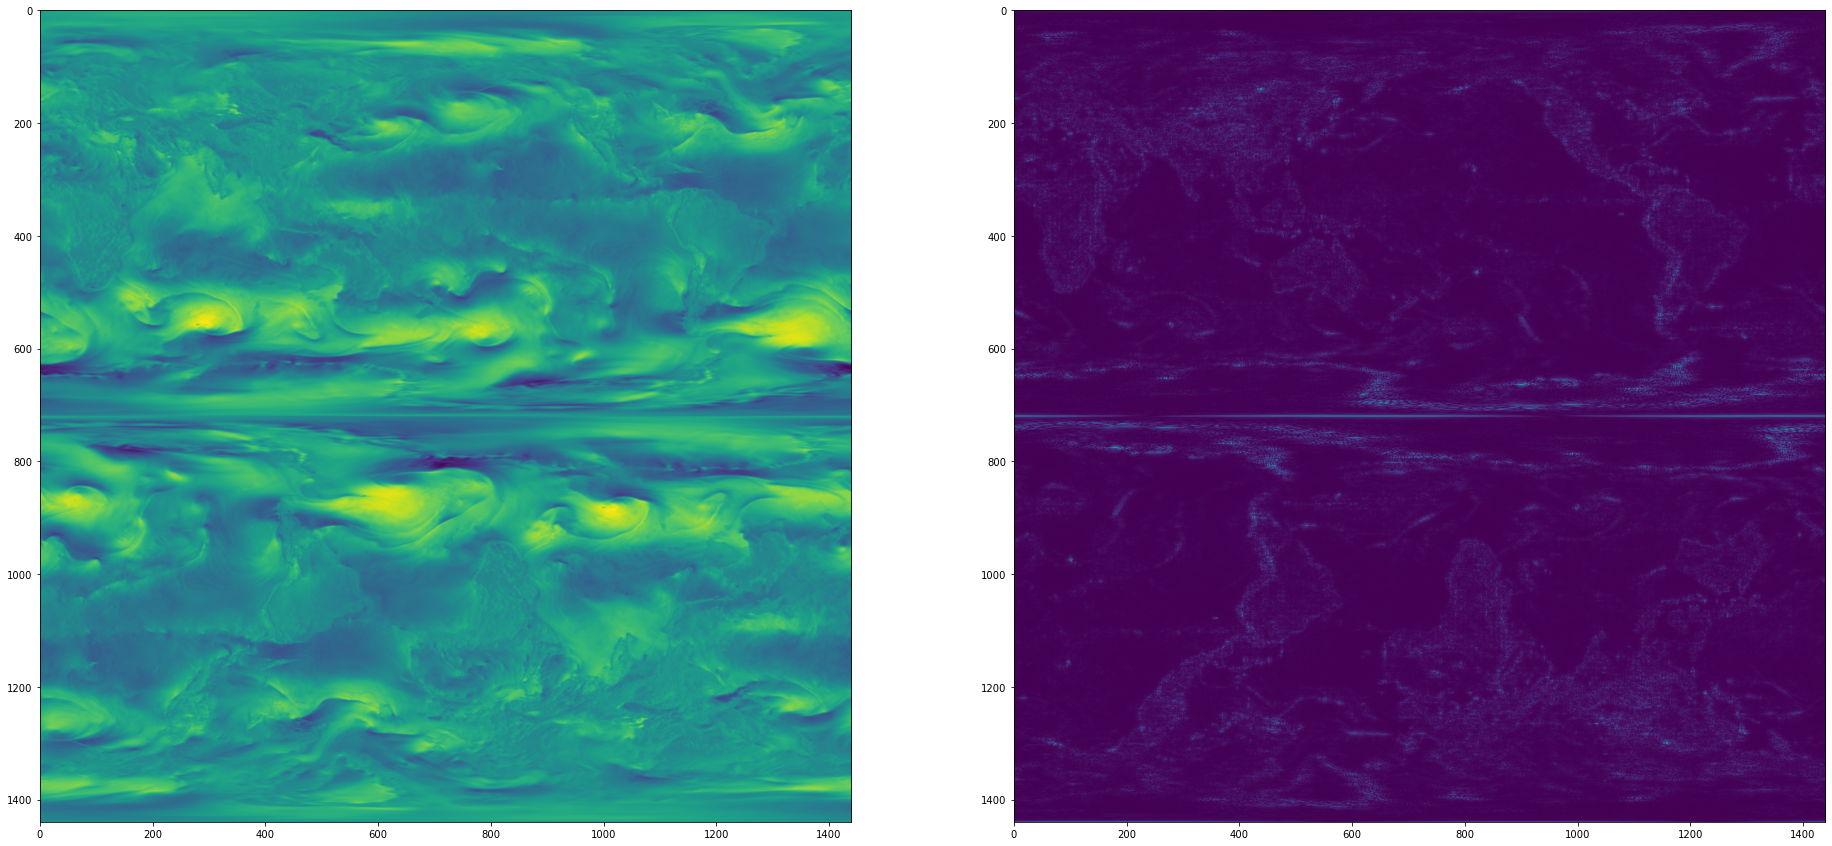

In [25]:

fig, axes = plt.subplots(1, 2, figsize=(32, 20))
axes[0].imshow(x[0][0])

x_recon = bworth(x)
# x_recon = mean_transform(x_recon, xlats_last)
axes[0].imshow(x_recon[0][0], vmax=x[0][0].max(), vmin=x[0][0].min())
axes[1].imshow((x - x_recon).abs()[0][0])


print((x - x_recon).abs().mean())


In [231]:
axes[0]

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

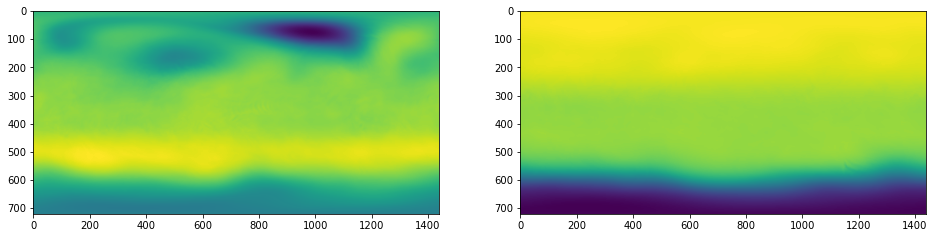

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(train_dataset[300][0][16])
axes[1].imshow(train_dataset[800][0][16])

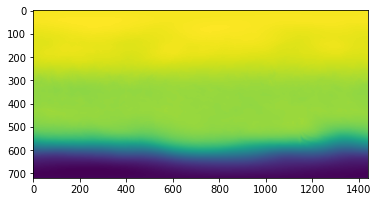

In [43]:
plt.imshow(train_dataset[800][0][16])

In [4]:
stds = np.load('/pscratch/sd/s/shas1693/data/era5/global_stds.npy')
means = np.load('/pscratch/sd/s/shas1693/data/era5/global_means.npy')
print(means.squeeze(), stds.squeeze())


[-6.42138980e-03  2.93685094e-01  2.79020667e+02  9.66010672e+04
  1.00906416e+05  2.74948004e+02  1.07133299e-02  3.00078022e-01
  6.98255676e+02  1.47735069e+00  2.15618633e-01  1.37356820e+04
  6.35723982e+00 -3.78661333e-02  5.41704141e+04  2.02868243e+02
  1.99242691e+05  4.99529678e+01  6.90421692e+01  1.87243168e+01
 -1.09157430e+04] [5.61282367e+00 4.77990804e+00 2.14241783e+01 9.66902320e+03
 1.38630084e+03 1.57404151e+01 6.19648580e+00 5.30953915e+00
 1.12948060e+03 8.28158120e+00 6.25006799e+00 1.56023251e+03
 1.19114704e+01 9.14528794e+00 3.43980139e+03 1.15453140e+01
 6.70269391e+03 3.35056749e+01 2.63248076e+01 1.62543545e+01
 1.56452264e+04]


In [5]:
with torch.no_grad():
    running_means = torch.zeros(20).cuda()

    i = 0
    for x, _, year, local in train_data_loader:
        x = x.cuda()
        if i % 5000 == 0:
            print(i, year, local, running_means/(i+1e-5))
        running_means += x.mean((0, 2, 3))
        i += 1
    running_means = running_means / i

0 tensor([0]) tensor([0]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
5000 tensor([3]) tensor([620]) tensor([-5.4443e-02,  1.5571e-01,  2.7814e+02,  9.6701e+04,  1.0097e+05,
         2.7427e+02, -4.1771e-02,  1.5512e-01,  7.4506e+02,  1.4349e+00,
         1.3695e-01,  1.3742e+04,  6.6674e+00, -2.9388e-02,  5.4073e+04,
         2.5274e+02,  1.9962e+05,  5.0755e+01,  7.0073e+01,  1.8230e+01],
       device='cuda:0')
10000 tensor([6]) tensor([1240]) tensor([-4.8802e-02,  1.7786e-01,  2.7829e+02,  9.6693e+04,  1.0096e+05,
         2.7435e+02, -3.1714e-02,  1.7644e-01,  7.4056e+02,  1.4316e+00,
         1.4224e-01,  1.3743e+04,  6.5865e+00, -2.6249e-02,  5.4081e+04,
         2.5276e+02,  1.9952e+05,  5.0741e+01,  7.0075e+01,  1.8295e+01],
       device='cuda:0')
15000 tensor([10]) tensor([400]) tensor([-4.8218e-02,  1.7099e-01,  2.7820e+02,  9.6690e+04,  1.0096e+05,
         2.7432e+02, -3.0500e-02,  1.6803e-01,  7.3755e+0

RuntimeError: The size of tensor a (20) must match the size of tensor b (1440) at non-singleton dimension 3

In [9]:
with torch.no_grad():
    running_var = torch.zeros(20).cuda()
    i = 0
    for x, _, year, local in train_data_loader:
        x = x.cuda()
        if i % 5000 == 0:
            print(i, year, local, running_var/(i+1e-5))
        running_var += ((x - running_means.unsqueeze(0).unsqueeze(2).unsqueeze(2))**2).sum((0, 2, 3))
        i += 1
    running_var = running_var / (i-1)

0 tensor([0]) tensor([0]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
5000 tensor([3]) tensor([620]) tensor([3.1314e+07, 2.3076e+07, 4.6676e+08, 9.4366e+13, 1.8239e+12, 2.5143e+08,
        3.8384e+07, 2.8713e+07, 1.1732e+12, 6.7598e+07, 4.0260e+07, 2.1742e+12,
        1.4744e+08, 8.7996e+07, 1.1449e+13, 1.7560e+08, 3.2737e+13, 1.1570e+09,
        6.9192e+08, 2.7743e+08], device='cuda:0')
10000 tensor([6]) tensor([1240]) tensor([3.1422e+07, 2.3192e+07, 4.6635e+08, 9.4505e+13, 1.8245e+12, 2.5202e+08,
        3.8468e+07, 2.8762e+07, 1.1805e+12, 6.7829e+07, 4.0167e+07, 2.2044e+12,
        1.4806e+08, 8.7594e+07, 1.1532e+13, 1.7579e+08, 3.5661e+13, 1.1540e+09,
        6.9064e+08, 2.7554e+08], device='cuda:0')
15000 tensor([10]) tensor([400]) tensor([3.1451e+07, 2.3162e+07, 4.6782e+08, 9.4319e+13, 1.8308e+12, 2.5223e+08,
        3.8519e+07, 2.8727e+07, 1.1826e+12, 6.8301e+07, 4.0216e+07, 2.2118e+12,
        1.4839e+08, 8.76

In [18]:
running_stds = (running_var/(1440*720)   ) .sqrt()

In [14]:
stds.shape

(1, 21, 1, 1)

In [19]:
np_means = running_means.unsqueeze(0).unsqueeze(2).unsqueeze(2).cpu().numpy()
np_stds = running_stds.unsqueeze(0).unsqueeze(2).unsqueeze(2).cpu().numpy()

In [21]:
final_np_means = means.copy()
final_np_means[:, :20] = np_means
final_np_stds = stds.copy()
final_np_stds[:, :20] = np_stds


In [23]:
final_np_stds.squeeze()

array([5.54144478e+00, 4.76372194e+00, 2.12314301e+01, 9.53605664e+03,
       1.32916870e+03, 1.55984058e+01, 6.13505983e+00, 5.30640507e+00,
       1.06940344e+03, 8.17955589e+00, 6.26403046e+00, 1.46708655e+03,
       1.19752798e+01, 9.17994976e+00, 3.35056274e+03, 1.30646362e+01,
       5.87842920e+03, 3.35615730e+01, 2.63984680e+01, 1.63616943e+01,
       1.56452264e+04])

In [25]:
np.save( '/pscratch/sd/m/mmccabe/data/era5/global_means.npy', final_np_means)
np.save('/pscratch/sd/m/mmccabe/data/era5/global_stds.npy', final_np_stds)

In [3]:
torch

<module 'torch' from '/global/homes/m/mmccabe/.local/perlmutter/pytorch1.9.0/lib/python3.8/site-packages/torch/__init__.py'>

In [63]:
linear = torch.nn.Linear(5, 10)
x = torch.randn(1, 5)
y = torch.randn(1, 10)
y2 = torch.randn(1, 10)

yhat = linear(x)
# yhat.register_hook(lambda x: print(x))
yhat2 = yhat.clone()
# yhat2.register_hook(lambda x: print('2', x))


loss = ((yhat - y)**2).sum() + ((yhat2 - y2)**2).sum()
# loss.backward()

In [64]:

    
    
def bw_hook(m, grad_input, grad_output):
    print(m)
    print(grad_input)
    print(grad_output)
    return (torch.zeros_like(grad_input[0]),)
    
m = DoubleOut()
m.register_full_backward_hook(bw_hook)

yhat1, yhat2 = m(yhat)

(yhat1.sum() + yhat2.sum()).backward()
print([p.grad for p in linear.parameters()])
print('zooooooom')

DoubleOut()
(tensor([[2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]]),)
(tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]))
[tensor([[0., -0., 0., -0., 0.],
        [0., -0., 0., -0., 0.],
        [0., -0., 0., -0., 0.],
        [0., -0., 0., -0., 0.],
        [0., -0., 0., -0., 0.],
        [0., -0., 0., -0., 0.],
        [0., -0., 0., -0., 0.],
        [0., -0., 0., -0., 0.],
        [0., -0., 0., -0., 0.],
        [0., -0., 0., -0., 0.]]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]
zooooooom


In [41]:
??torch.nn.modules.module.register_module_full_backward_hook

Signature:
torch.nn.modules.module.register_module_full_backward_hook(
    hook: Callable[[ForwardRef('Module'), Union[Tuple[torch.Tensor, ...], torch.Tensor], Union[Tuple[torch.Tensor, ...], torch.Tensor]], Union[NoneType, torch.Tensor]],
) -> torch.utils.hooks.RemovableHandle
Source:   
def register_module_full_backward_hook(
    hook: Callable[['Module', _grad_t, _grad_t], Union[None, Tensor]]
) -> RemovableHandle:
    r"""Registers a backward hook common to all the modules.

    .. warning ::
        This adds global state to the `nn.module` module
        and it is only intended for debugging/profiling purposes.

    The hook will be called every time the gradients with respect to module
    inputs are computed. The hook should have the following signature::

        hook(module, grad_input, grad_output) -> Tensor or None

    The :attr:`grad_input` and :attr:`grad_output` are tuples. The hook should
    not modify its arguments, but it can optionally return a new gradient with
  

In [50]:
import torch 
import torch.nn as nn

class myNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Conv2d(3,10,2, stride = 2)
    self.relu = nn.ReLU()
    self.flatten = lambda x: x.view(-1)
    self.fc1 = nn.Linear(160,5)
   
  
  def forward(self, x):
    x = self.relu(self.conv(x))
    return self.fc1(self.flatten(x))
  

net = myNet()

def hook_fn(m, i, o):
  print(m)
  print("------------Input Grad------------")

  for grad in i:
    try:
      print(grad.shape)
    except AttributeError: 
      print ("None found for Gradient")

  print("------------Output Grad------------")
  for grad in o:  
    try:
      print(grad.shape)
    except AttributeError: 
      print ("None found for Gradient")
  print("\n")

class DoubleOut(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x, x

net.conv.register_full_backward_hook(hook_fn)
net.fc1.register_full_backward_hook(hook_fn)
inp = torch.randn(1,3,8,8)
out = net(inp)
double = DoubleOut()
double.register_full_backward_hook(hook_fn)

out, out2 = double(out)

loss = (1 - out.mean()) + (1 - out2.mean())
loss.backward()

DoubleOut()
------------Input Grad------------
torch.Size([5])
------------Output Grad------------
torch.Size([5])
torch.Size([5])


Linear(in_features=160, out_features=5, bias=True)
------------Input Grad------------
torch.Size([160])
------------Output Grad------------
torch.Size([5])


Conv2d(3, 10, kernel_size=(2, 2), stride=(2, 2))
------------Input Grad------------
None found for Gradient
------------Output Grad------------
torch.Size([1, 10, 4, 4])




In [ ]:
class ContSphereEmbedding(nn.Module):
    def __init__(self, hidden_features, grid_shape, samples_per_year=1460, sph_order=20, max_date_freq=6, max_lat_freq=4, layer_size=1000, scale_factor=.02, sphere=True):
        super().__init__()
        self.grid_shape = grid_shape
        self.hidden_features = hidden_features
        self.sphere = sphere
        # If operating in space, use spherical harmonics for spatial locations
        # Otherwise assume frequency space and just use sign(wave number)*log1p(abs(wave number))
        if sphere:
            grid_coords = torch.cartesian_prod(torch.linspace(0, np.pi, grid_shape[0]+2)[1:-1], torch.linspace(0, 2*np.pi, grid_shape[1]+1)[:-1])
            space_features = spherical_harmonics_alpha_beta(list(range(1, sph_order+1)), grid_coords[:, 1], grid_coords[:, 0])
            self.register_buffer('time_coords', grid_coords[:, 1].reshape(-1, 1)/(2*np.pi))
            self.register_buffer('lats', grid_coords[:, :1])
            self.register_buffer('time_base', (torch.arange(1, max_date_freq//2+1)*2*np.pi).reshape(1, -1))
            self.register_buffer('date_base', (torch.arange(1, max_date_freq+1, 1)*2*np.pi / 365).reshape(1, -1), persistent=False) # Could probably use a small number of freqs here
            num_feats = space_features.shape[1]+2*(self.time_base.shape[1] + (max_lat_freq-1)*self.date_base.shape[1])
        else:
            grid_coords = torch.cartesian_prod(torch.fft.fftfreq( grid_shape[0])*grid_shape[0], torch.fft.rfftfreq(grid_shape[1])*grid_shape[1])
            grid_sgns = torch.sign(grid_coords)
            grid_coords = torch.log1p(grid_coords.abs()+1e-5)*grid_sgns
            self.grid_shape = torch.fft.fftfreq(grid_shape[0]).shape[0], torch.fft.rfftfreq(grid_shape[1]).shape[0]
            stack_feats = []
            #for i in range(0, sph_order+1):
            #    for j in range(0, sph_order+1):
            #        x = eval_legendre(i, grid_coords[:, 1]).float()
            #        y = eval_legendre(j, grid_coords[:, 0]).float()
            #        stack_feats.append(x*y)
            space_features = grid_coords #torch.stack(stack_feats, -1)
            num_feats = space_features.shape[1]
        self.register_buffer('space_features', space_features)
        self.mlp = nn.Sequential(nn.Linear(num_feats, layer_size),
            nn.GLU(),
            nn.Linear(layer_size//2, hidden_features, bias=False)
            )
        self.scale_factor = scale_factor
        self.samples_per_year = samples_per_year

    def datetime_features(self, dt_ind):
        # Within year - dt_ind is 4*day + hours
        day = dt_ind // 4
        xprod_date = day*self.date_base
        # Within day
        time = (dt_ind % 4) / 4
        # If these are spatial coordinates account for solar time offsets
        if self.sphere:
            time = (self.time_coords + time) % 1
            #xprod_date = xprod_date.expand(time.shape[0], -1)
            xprod_date = torch.cat([xprod_date * torch.cos(k*self.lats) for k in range(1, 4)], -1)
            #daylight = day_length(day, self.lons)
        coses_date = torch.cos(xprod_date)
        sins_date = torch.sin(xprod_date)
        xprod_time = time*self.time_base
        coses_time = torch.cos(xprod_time)
        sins_time = torch.sin(xprod_time)
        return torch.cat([coses_time, sins_time, coses_date, sins_date], dim=-1)

    def forward(self, dt_ind):
        # Remember to fix this for larger batches
        dt_ind = dt_ind.reshape(-1, 1)
        feats = [self.space_features]
        if self.sphere:
            dt_feats = self.datetime_features(dt_ind)
            feats.append(dt_feats)
        return self.scale_factor*self.mlp(torch.cat(feats, -1)).reshape(1, *self.grid_shape, self.hidden_features)
    
    
class AFNO2D(nn.Module):
    def __init__(self, hidden_size, grid_size, num_blocks=8, sparsity_threshold=0.01, hard_thresholding_fraction=1, hidden_size_factor=1):
        super().__init__()
        assert hidden_size % num_blocks == 0, f"hidden_size {hidden_size} should be divisble by num_blocks {num_blocks}"

        self.hidden_size = hidden_size
        self.sparsity_threshold = sparsity_threshold
        self.num_blocks = num_blocks
        self.block_size = self.hidden_size // self.num_blocks
        self.hard_thresholding_fraction = hard_thresholding_fraction
        self.hidden_size_factor = hidden_size_factor
        # Quick Kaiming init (haven't done complex math to make sure its correct)
        self.scale1 = 1 / self.block_size**.5
        self.scale2 = 1 / (self.block_size*hidden_size_factor/2)**.5
        self.conv_gen1 = ContSphereEmbedding(hidden_size, (180, 180), sphere=False)
        self.conv_gen2 = ContSphereEmbedding(hidden_size, (180, 180),  sphere=False)

        base_weight1 = self.scale1 * torch.randn(self.num_blocks, self.block_size, self.block_size * self.hidden_size_factor, dtype=torch.cfloat)
        base_weight2 = self.scale2 * torch.randn(self.num_blocks, self.block_size//2 * self.hidden_size_factor, self.block_size, dtype=torch.cfloat)

        self.w1 = nn.Parameter(torch.stack([base_weight1.real, base_weight1.imag], dim=-1))
        self.w2 = nn.Parameter(torch.stack([base_weight2.real, base_weight2.imag], dim=-1))

    def forward(self, x, dt_ind):
        dtype = x.dtype
        #x = sphere_to_torus(x)
        x = x.float()
        B, H, W, C = x.shape

        x = torch.fft.rfft2(x, dim=(1, 2), norm="ortho")
        # Phase-only conv
        filt1 = torch.exp(2j*np.pi*self.conv_gen1(dt_ind).reshape(B, H, W//2+1, self.num_blocks, self.block_size))
        # Magnitude-only conv
        filt2 = (self.conv_gen2(dt_ind).reshape(B, H, W//2+1, self.num_blocks, self.block_size))

        x = x.reshape(B, H, W // 2 + 1, self.num_blocks, self.block_size)

        o1_real = torch.zeros([B, H, W // 2 + 1, self.num_blocks, self.block_size * self.hidden_size_factor], device=x.device)
        o1_imag = torch.zeros([B, H, W // 2 + 1, self.num_blocks, self.block_size * self.hidden_size_factor], device=x.device)
        o2_real = torch.zeros(x.shape, device=x.device)
        o2_imag = torch.zeros(x.shape, device=x.device)


        total_modes = H // 2 + 1

        o1_real = complex_glu(
            torch.einsum('...bi,bio->...bo', x, torch.view_as_complex(self.w1)) * filt1 # + \
         #   bias1
        )
        o2_real  = filt2 * (
            torch.einsum('...bi,bio->...bo', o1_real, torch.view_as_complex(self.w2))# + \
          #  bias2
        )

        x = o2_real
        x = x.reshape(B, H, W // 2 + 1, C)#*torch.sigmoid(self.freq_filter)
        #x = torch.fft.ifft(x, n=H, dim=1, norm="ortho")#[:, :H//2]
        x = torch.fft.irfft2(x, n=W, dim=(1,2), norm="ortho")
        x = x.type(dtype)#[..., :H//2, :, :]
        return x